# <a id='4' href=#1> Importing Libraries </a>

In [1]:
# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np

#libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,RobustScaler,\
                                    OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


#modeling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

#model improvement
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.inspection import permutation_importance

#evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error,\
                            r2_score,mean_absolute_percentage_error

#storing and loading 
import joblib
import json

import warnings
warnings.filterwarnings('ignore')

# <a id='5' href=#1> Data Loading  </a>

In [2]:
df= pd.read_csv('insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# <a id='6' href=#1> Exploratory Data Analysis (EDA) </a>

Let's start by examining the shape of the data and the data type of each attribute.

In [4]:
print(f'Shape of the data: {df.shape}')
print(f'There are {df.shape[0]} rows in the data.\n')

df.info()

Shape of the data: (1338, 7)
There are 1338 rows in the data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
# select columns of object data type 
categorical_cols= list(df.select_dtypes(include='object'))
categorical_cols

['sex', 'smoker', 'region']

In [6]:
# select columns of numeric data type 
numerical_cols= list(df.select_dtypes(include='number'))
numerical_cols

['age', 'bmi', 'children', 'charges']

Observation result:
- There are 3 columns of categorical data that are already in the form of objects, so we don't need to change the data type anymore.
- There are 4 columns of numerical type:
   - Age, body mass index (BMI), and charges are classified as continuous numerical.
   - The number of children is a discrete numerical .

Next, we are going to identify duplicated data.

In [7]:
print('the total number of duplicated rows:',
      df.duplicated().sum())

the total number of duplicated rows: 1


In [8]:
# identify and retrieve rows that are duplicates
df[df.duplicated(keep=False)]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


If duplicate data exists in the dataset, it can cause bias in analysis and modeling. Duplicated data does not provide useful information, so removing it improves the quality of our understanding of the dataset.

In [9]:
# remove duplicate rows
df.drop_duplicates(keep='first', inplace=True)

print('the total number of duplicated rows:',
      df.duplicated().sum())

the total number of duplicated rows: 0


Next, we are going to check the missing data

In [10]:
# Calculate the total missing value in each column
missing_values = df.isnull().sum()

# Calculate the percentage of missing values in each column
percentage_missing_values = (missing_values / len(df)) * 100

# Create a new dataframe to store the total and percentage of missing values
missing_df = pd.DataFrame(
    {'Total Missing Values': missing_values, 
     'Percentage': percentage_missing_values})

missing_df

,Total Missing Values,Percentage
age,0,0.0
sex,0,0.0
bmi,0,0.0
children,0,0.0
smoker,0,0.0
region,0,0.0
charges,0,0.0


We can see that there is no missing values (null values). Now, let's explore our data using descriptive statistics to gain some insights.

In [11]:
# summary statistics of categorical columns
df[categorical_cols].describe()

,sex,smoker,region
count,1337,1337,1337
unique,2,2,4
top,male,no,southeast
freq,675,1063,364


In [12]:
# Loop through the categorical columns and print unique values in each column
for col in categorical_cols:
  print(f'unique values in a column {col}:\
  \n{df[col].unique()}\n')

unique values in a column sex:  
['female' 'male']

unique values in a column smoker:  
['yes' 'no']

unique values in a column region:  
['southwest' 'southeast' 'northwest' 'northeast']



Observation results on categorical data: 
- There are no attributes or columns that have a high cardinality. This can be seen from the low number of unique values in each column.
- In the sex column, we can see that most of the respondents are male.
- Most of the respondents are not smokers and live in the southeast region

In [13]:
# Create a function to calculate value counts for a specified variable
def val_counts(df, var):
    results = df[var].value_counts(sort=False)
    labels = results.index
    counts = results.values
    return labels, counts

labels = val_counts(df, 'sex')[0]
values= val_counts(df, 'sex')[1]
colors = ['#bb2b77','#95cbee']
explode = (0.05, 0) # Explode the first slice for emphasis 

def visualize_piechart(labels=None, values= None, 
                       explode=None, colors=colors,var=None):
    
    ## Create a Pie chart
    fig = go.Figure(data=[go.Pie(labels=labels, values=values, 
                                 pull=explode, 
                                 marker=dict(
                                     colors=colors,
                                     line=dict(color='#000000', width=2)))])

    # Adjusting the position of the horizontal legend
    fig.update_layout(
        legend=dict(
            x=0.5, y=1.15, 
            xanchor='center',
            orientation='h',  # Horizontal orientation
            bgcolor='rgba(211,211,211,0.3)',  # legend background
            font=dict(size=12)    
        ),
        title=dict(text=f'{var} Distribution', x=0.5, y=0.95) 
    )
    
    return fig.show()

In [14]:
visualize_piechart(labels=labels, values= values,explode=explode,var='Gender')

The gender distribution of each respondent in this dataset is almost even with 662 Females (49.5%) and 675 Males (50.5%)


In [15]:
smoker_labels = val_counts(df, 'smoker')[0]
smoker_values= val_counts(df, 'smoker')[1]

visualize_piechart(labels=smoker_labels, values= smoker_values,
                   explode=explode,var='Smoker')

The majority of respondents were smokers with a total of 274 smokers (20.5%) and 1093 non-smokers (79.5%). Next, let's check the status of smokers by gender

In [16]:
# Querying the DataFrame to separate data for non-smokers and smokers
query_smoker_no= df.query('smoker=="no"')
query_smoker_yes= df.query('smoker=="yes"')

labels_no = val_counts(query_smoker_no, 'sex')[0]
values_no= val_counts(query_smoker_no, 'sex')[1]
labels_yes = val_counts(query_smoker_yes, 'sex')[0]
values_yes= val_counts(query_smoker_yes, 'sex')[1]


# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=labels_no, values=values_no, 
                     marker=dict(colors=colors)
                    ),
              row=1, col=1)
fig.add_trace(go.Pie(labels=labels_yes, values=values_yes, 
                     marker=dict(colors=colors)
                    ),
              row=1, col=2)

# Use `hole` to create a donut-like pie chart
# Use `hoverinfo` to define what information is displayed 
# when the user hovers the cursor over data points
fig.update_traces(hole=.4, hoverinfo="label+value+percent+name")

fig.update_layout(
    title_text="Distribution of Smoker by Gender",

    # Add annotations in the center of the donut pies.
    annotations=[dict(text='No', x=0.20, y=0.5, font_size=20, showarrow=False),
                 dict(text='Yes', x=0.81, y=0.5, font_size=20, showarrow=False)],
    
    # Adjusting the position of legend
    legend=dict(x=0.5, y=1.1, xanchor='center',
        orientation='h',  # Horizontal orientation
        bgcolor='rgba(211,211,211,0.3)',  # legend background color
        font=dict(size=12))
)
fig.show()

In [17]:
# Count the number of smokers in each region
labels_no = val_counts(query_smoker_no, 'region')[0]
values_no= val_counts(query_smoker_no, 'region')[1]
labels_yes = val_counts(query_smoker_yes, 'region')[0]
values_yes= val_counts(query_smoker_yes, 'region')[1]

colors= ['#A721F4','#F22E8B','#95cbee','#6A2EF2']

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=labels_no, values=values_no, marker=dict(colors=colors)),
              row=1, col=1)
fig.add_trace(go.Pie(labels=labels_yes, values=values_yes, marker=dict(colors=colors)),
              row=1, col=2)

fig.update_traces(hole=.4, hoverinfo="label+value+percent+name")

fig.update_layout(
    title_text="Distribution of Smoker by Region",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='No', x=0.20, y=0.5, font_size=20, showarrow=False),
                 dict(text='Yes', x=0.80, y=0.5, font_size=20, showarrow=False)],
    
    # Adjusting the position of legend
    legend=dict(x=0.5, y=1.1, xanchor='center',
        orientation='h',  # Horizontal orientation
        bgcolor='rgba(211,211,211,0.3)',  # legend background
        font=dict(size=12))
)
fig.show()

Observation results:
- Among the 274 smokers, the proportion of males is higher than that of females. The percentage of male smokers is 58%, while the percentage of female smokers is 20%.
- The Southeast region has the highest number of smokers compared to other regions.

In [18]:
# summary statistics of numerical columns
df[numerical_cols].describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


In [19]:
df['children'].value_counts()

children
0    573
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64

Observation results:
1. Based on their distribution, the `age` and `bmi` variables appear to be fairly symmetrical. This is because the mean and median (50th percentile) values are close together. This also indicates that there is a possibility of normal distribution or uniform distribution. To ensure this distribution, we will check it with visualization in the next stage.
2. There is no indication of data having an unreasonable value (anomalous data).
3. Most of the respondents have a body mass index (BMI) in the range of 26-35.
4. Most of the respondents have a number of children or dependents that are close to the median or in the range 0 to 2 (if viewed from the first to the third quartile). Thus, the majority of respondents have relatively few children or dependents.


Next, we will try to look at the data distribution of `Charges` and `BMI`

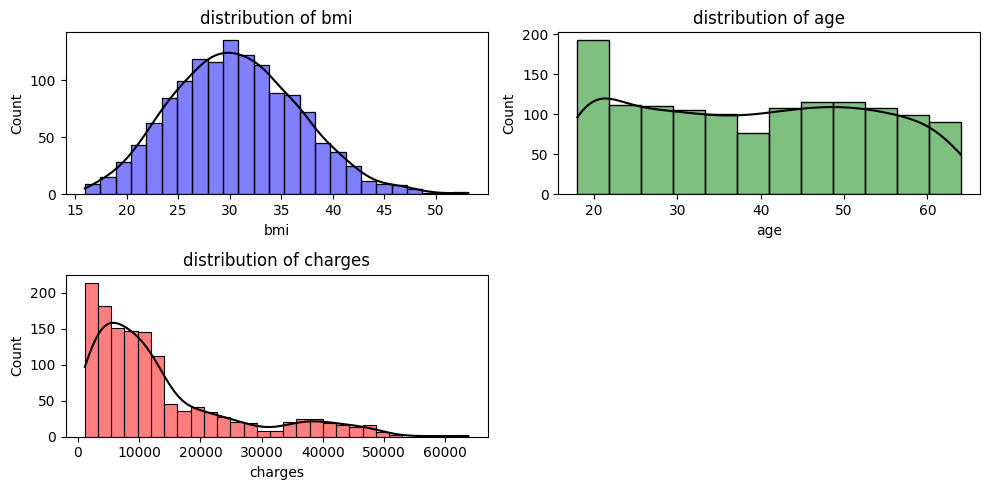

In [20]:
# Creating a subplot with 1 row and 3 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

# Looping through each variable
var_dict={'bmi':'blue','age':'green','charges': 'red'}
row_col = [(0, 0), (0, 1), (1, 0)]  # (row, col)
for i,(var,color) in enumerate(var_dict.items()):
    row, col= row_col[i]
    #row = (i // 2) + 1
    #col = (i % 2) + 1
    sns.histplot(data=df, x=var, kde=True, ax=axes[row, col], color=color)
    axes[row, col].set_title(f'distribution of {var}')
    axes[row, col].lines[0].set_color('black')

# Remove the unused subplot
fig.delaxes(axes[1, 1])

# Adjusting plot layout
plt.tight_layout()

# Displaying the plot
plt.show()

In [21]:
# Calculating skewness and kurtosis
skewness_kurtosis = df[['bmi', 'age', 'charges']].agg(['skew', 'kurt'])
skewness_kurtosis.T

,skew,kurt
bmi,0.283914,-0.052947
age,0.054781,-1.244406
charges,1.515391,1.604221


Insights:
- The `Age` of the insured approximately follow a uniform distribution with lowest age being 18 and highest being 64.
- The distribution of `BMI` tends to be normally distributed, while the charges are quite right-skewed or asymmetrical.
- There are indications of outliers in the `charges` variable (many values are located at the tail of the distribution or at extreme points), because the kurtosis tends to be high and the distribution is positively skew. So, we will try to check it by box plot.

In [22]:
def check_outliers(var):
    # Calculating total outliers
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    total_outliers = len(df[(df[var] < lower_bound) | (df[var] > upper_bound)])
    return total_outliers, lower_bound, upper_bound

It can be seen that there are outliers in `BMI` and `Charges`, especially in the `Charges` variable, we see that there are lots of outliers. However, for this project, we will keep the outliers in our data. In the model development, we will attempt to examine the effects of these outliers on our model. This approach will provide insights into how the model responds to outlier data points and whether it can handle them effectively. Next, let's check the correlation between the two variables.

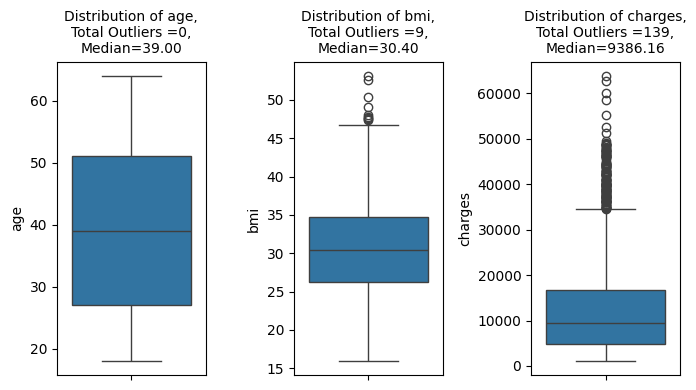

In [23]:
# Creating a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 3, figsize=(7, 4))


# Looping through each variable
for i, var in enumerate(['age','bmi','charges']):
    sns.boxplot(data=df, y=var, ax=axes[i],)
    title= f'Distribution of {var},\nTotal Outliers ={check_outliers(var)[0]},\nMedian={df[var].median():.2f}'
    
    axes[i].set_title(title,fontsize=10)


# Adjusting plot layout
plt.tight_layout()

# Displaying the plot
plt.show()

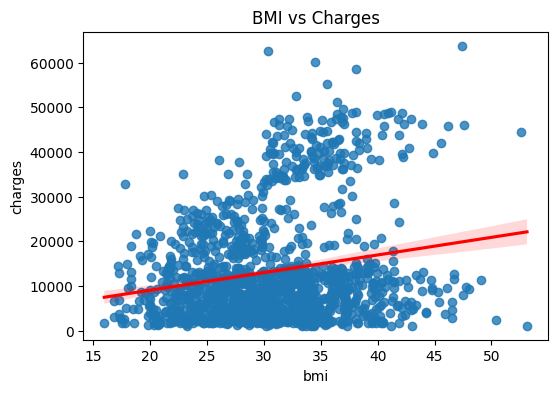

In [24]:
# Plotting BMI vs Charges scatter plot
plt.figure(figsize=(6,4))
sns.regplot(data=df, x='bmi', y='charges', line_kws={"color": "red"})
plt.title('BMI vs Charges');

Based on bivariate analysis, it seems that there is a slight linear relationship between `BMI` and `Charges`, but we will try to check it by considering the status of the smoker variable (multivariate analysis)

In [25]:
color = {'yes': '#DC143C', 'no': '#1E90FF'}
fig = px.scatter(df, x="bmi", y="charges", trendline="ols", 
                 color='smoker', color_discrete_map=color)

fig.update_layout(
    height=500,  
    width=600,
    title= 'Relationship between BMI, Charges, and Smoking Status'
)
fig.show()

Based on multivariate analyisis, we can see that there is a linear relationship between `BMI` and `Charges` (medical cost) when the status is a smoker. Smoking has the biggest impact on medical costs, it can be seen that charges tend to increase significantly as BMI increases. How about the relationship between charges and age?

In [26]:
fig = px.scatter(df, x="age", y="charges", trendline="ols", 
                 color='smoker',color_discrete_map=color)

fig.update_layout(
    height=500,  
    width=600,
    title= 'Relationship between Age, Charges, and Smoking Status'
)
fig.show()

It seems that the insurance premiums tend to increase slightly with age for both smokers and non-smokers. How about the relationship between charges and children?

In [27]:
# Because children are discrete numbers from 0-5, We use box plots to make it easier to see patterns from the data.
fig = px.box(df, x="children", y="charges", color="smoker",
            color_discrete_map=color)
fig.show()


From the visualization above, it can be seen that smokers tend to have high cost, whether they have few or many children. So we can assume that the number of children does not affect medical costs,

In [28]:
fig = px.box(df, x="sex", y="charges",color='smoker',
            color_discrete_map=color)
fig.show()


In [29]:
df.query("smoker=='yes'").groupby(['sex'])['charges'].median().sort_values()

sex
female    28950.4692
male      36085.2190
Name: charges, dtype: float64

It appears that the insurance premiums for male smokers tend to be higher than those for females. However, this is likely due to the higher prevalence of smoking among males. Next, let's examine the distribution of premiums by region.

In [30]:
fig = px.box(df, x="region", y="charges",
            color_discrete_map=color)
fig.show()


In [31]:
df.groupby(['region'])['charges'].median().sort_values()

region
southwest     8798.593000
northwest     8976.977250
southeast     9294.131950
northeast    10057.652025
Name: charges, dtype: float64

Based on the median value, it seems that the southwest region tends to have smaller medical costs compared to other regions, while the northeast has higher costs.

# Hypothesis Testing

In this stage, we will attempt to answer the question: **"Does the insurance bill for people who smoke differ significantly from people who don't smoke?"**

To answer this question we will use hypothesis testing.

* $H_0$: $\mu_s$ = $\mu_n$ 
* $H_A$: $\mu_s$ != $\mu_n$

Where:
 - $\mu_s$ = Mean Charges of all smokers
 - $\mu_n$ = Mean Charges of all non - smokers 

In [32]:
smokers = df.query("smoker=='yes'")
non_smokers = df.query("smoker=='no'")
charge_smokers = smokers['charges']
charge_non_smokers = non_smokers['charges']

print(f'Variance in charges of smokers: {np.var(charge_smokers):.2f}')
print(f'Variance in charges of non-smokers: {np.var(charge_non_smokers):.2f}')
print(f'mean in charges of smokers: {np.mean(charge_smokers):.2f}')
print(f'mean in charges of non-smokers: {np.mean(charge_non_smokers):.2f}')

Variance in charges of smokers: 132721153.14
Variance in charges of non-smokers: 35881947.82
mean in charges of smokers: 32050.23
mean in charges of non-smokers: 8440.66


In [33]:
from scipy.stats import ttest_ind

# Perform t-test
t_statistic, p_value = ttest_ind(charge_smokers, charge_non_smokers, equal_var=False)
print(f't_statistic: {t_statistic}\np_value: {p_value}')

# Set the significance level (alpha)
alpha = 0.05

# Compare p-value with alpha and make a conclusion
if p_value < alpha:
    print("Reject the null hypothesis: mean charges for smokers and non-smokers are different.")
else:
    print("Fail to reject the null hypothesis: No significant difference in mean charges between smokers and non-smokers.")

t_statistic: 32.7423097372529
p_value: 6.261720774727631e-103
Reject the null hypothesis: mean charges for smokers and non-smokers are different.


Based on the results of t-test we will reject H0, but keep in mind that when using the t-test we assume the data distribution is normal, whereas we have checked that the data distribution on `charges` tends to be skewed and has outliers. Therefore, here we will test with Mann-Whitney U.


State the null and alternative hypothesis:
* $H_0$: $\tilde{x}_s$ = $\tilde{x}_n$
* $H_A$: $\tilde{x}_s$ != $\tilde{x}_n$

Where:
 - $\tilde{x}_s$ = Charges of all smokers
 - $\tilde{x}_n$ = Charges of all non - smokers 

In [34]:
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(charge_smokers, charge_non_smokers, alternative='two-sided')

print(f'Mann-Whitney U statistic: {statistic}')
print(f'p_value: {p_value}')

# Compare p-value with alpha and make a conclusion
if p_value < alpha:
    print("Reject the null hypothesis: There are significant differences in health insurance costs between smokers and non-smokers.")
else:
    print("Fail to reject the null hypothesis: No significant difference between smokers and non-smokers.")


Mann-Whitney U statistic: 283859.0
p_value: 5.74701188239214e-130
Reject the null hypothesis: There are significant differences in health insurance costs between smokers and non-smokers.


Based on the hypothesis testing we conducted, we conclude that the difference in the values of the two groups is not the result of mere chance, but has a strong basis from the data to be able to express a real or significant difference.

Next, we will attempt to check the correlation using Spearman correlation.
We use Spearman because it is non-parametric, and therefore, it does not require the assumption of normally distributed data.

In [35]:
df_new= df.copy()
df_new['smoker'] = df_new['smoker'].map({'no': 0, 'yes': 1})
df_new['sex'] = df_new['sex'].replace(['male','female'], [1,0])

# Perform one-hot encoding on the "region" column
df_encoded = pd.get_dummies(df_new, columns=['region'], dtype=float)

In [36]:
df_encoded.sample(5)

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
686,42,1,26.125,2,0,7729.64575,1.0,0.0,0.0,0.0
1278,39,1,29.925,1,1,22462.04375,1.0,0.0,0.0,0.0
1033,18,1,21.565,0,1,13747.87235,1.0,0.0,0.0,0.0
352,30,0,27.700,0,0,3554.20300,0.0,0.0,0.0,1.0
1108,26,1,30.000,1,0,2904.08800,0.0,0.0,0.0,1.0


In [37]:
def viz_heatmap(data=None):
    plt.figure(figsize=(8, 6))
    sns.heatmap(data, annot=True, fmt=".2f", 
                cmap = 'bwr', 
                mask=np.triu(data)); #only display the upper triangle of the correlation matrix

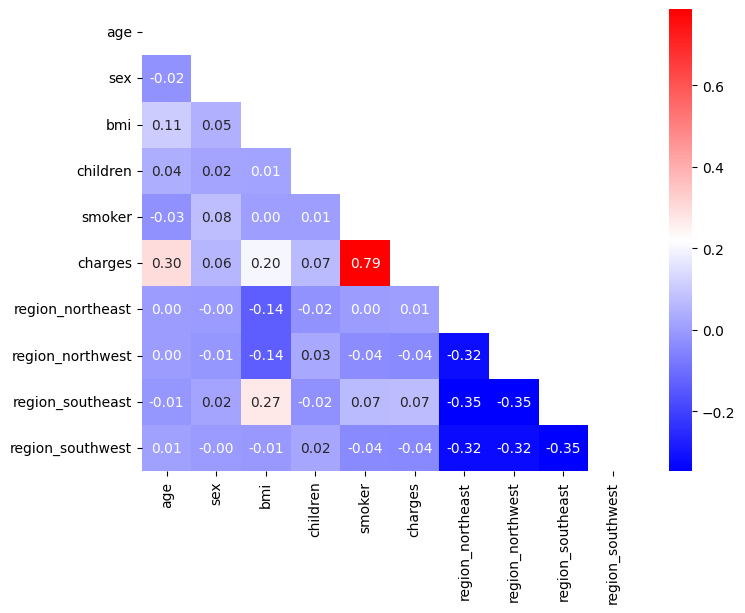

In [38]:
corr_1 = df_encoded.corr(method='pearson')
viz_heatmap(data=corr_1)

Based on the analysis with Pearson correlation, we can observe that the "smoker" feature has a high correlation, approximately 79%. We can also see that the "age" feature has a correlation of 30%, and "bmi" has a correlation of 20%. 

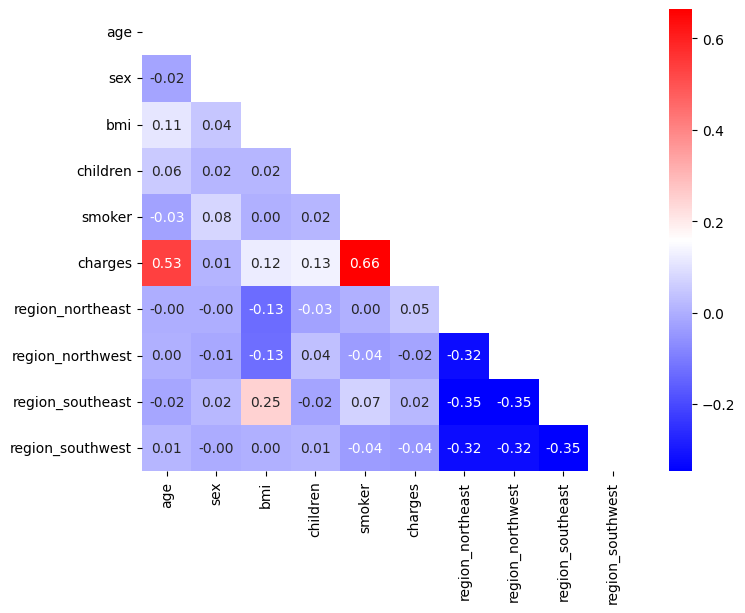

In [39]:
corr_2 = df_encoded.corr(method='spearman')
viz_heatmap(data=corr_2)

Based on the analysis with Spearman correlation, we can observe that the "smoker" feature has a high correlation, approximately 66%. We can also see that the "age" feature has a correlation of 53%, and "bmi" has a correlation of 25%. This suggests that these features may still have a significant influence on insurance bills compared to other features with lower correlations.

Next, we will conduct several experiments on Feature Engineering and Machine Learning Algorithms

# <a id='7' href=#1> Data Preprocessing </a>

In [40]:
X= df.drop('charges',axis=1)
y= df['charges']

In [41]:
X['region'].value_counts(normalize=True).round(2)

region
southeast    0.27
southwest    0.24
northwest    0.24
northeast    0.24
Name: proportion, dtype: float64

In [42]:
X_train,X_test,y_train, y_test= train_test_split(X,y,test_size=0.2,
                                                random_state=42,
                                                stratify=X[['smoker','sex','region']]
                                               )

In [43]:
print('X_train shape:',X_train.shape)
print('X_test shape:',X_test.shape)

X_train shape: (1069, 6)
X_test shape: (268, 6)


In [44]:
X_train['region'].value_counts(normalize=True).round(2)

region
southeast    0.27
southwest    0.24
northwest    0.24
northeast    0.24
Name: proportion, dtype: float64

In [45]:
X_train.head()

,age,sex,bmi,children,smoker,region
294,25,male,26.80,3,no,southwest
472,19,female,29.80,0,no,southwest
858,25,female,32.23,1,no,southeast
334,43,female,35.72,2,no,northeast
823,44,female,29.81,2,no,southeast


In [46]:
numerical_feature= ['bmi', 'children','age']
categorical_nominal= ['region']

categorical_biner = ['sex','smoker']
sex_values = ['female','male']
smoker_values = ['no','yes']

enc_1 = OrdinalEncoder(categories=[sex_values, smoker_values],
                     dtype='int8')

enc_2 = OneHotEncoder(sparse=False,dtype='int8')


numerical_pipeline= Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', MinMaxScaler())
])

categorical_biner_pipeline= Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoding_ordinal', enc_1),
])

categorical_nominal_pipepline= Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoding_ohe', enc_2),
])

In [47]:
preproc_pipeline= ColumnTransformer(
    [
        ('num_pipeline',numerical_pipeline, numerical_feature),
        ('encoder_biner',categorical_biner_pipeline, categorical_biner),
        ('encoder_nominal',categorical_nominal_pipepline, categorical_nominal)
    ],
    remainder='passthrough',
    verbose=True
)


In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

class DtypeConverter(BaseEstimator, TransformerMixin):
    def __init__(self, dtype=np.float64):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.astype(self.dtype)

    
convert_pipeline = Pipeline([
    ('preprocessor', preproc_pipeline),
    ('dtype_converter', DtypeConverter(dtype=np.float32))  # Convert to float32
])

In the given syntax, we are attempting to change the array's default type from float64 to float32. This is done to reduce the memory size being used.

In [49]:
X_train_new= convert_pipeline.fit_transform(X_train)
X_test_new= convert_pipeline.transform(X_test)

[ColumnTransformer] .. (1 of 3) Processing num_pipeline, total=   0.0s
[ColumnTransformer] . (2 of 3) Processing encoder_biner, total=   0.0s
[ColumnTransformer]  (3 of 3) Processing encoder_nominal, total=   0.0s


In [50]:
X_train_new.dtype

dtype('float32')

In [51]:
# Getting a list of column names after encoding
encoded_columns = preproc_pipeline.named_transformers_['encoder_nominal'].\
                  get_feature_names_out(categorical_nominal)

columns= (list(numerical_feature) + list(categorical_biner) + list(encoded_columns))


X_train_new = pd.DataFrame(X_train_new,columns=columns)
X_test_new = pd.DataFrame(X_test_new,columns=columns)

In [52]:
X_train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bmi               1069 non-null   float32
 1   children          1069 non-null   float32
 2   age               1069 non-null   float32
 3   sex               1069 non-null   float32
 4   smoker            1069 non-null   float32
 5   region_northeast  1069 non-null   float32
 6   region_northwest  1069 non-null   float32
 7   region_southeast  1069 non-null   float32
 8   region_southwest  1069 non-null   float32
dtypes: float32(9)
memory usage: 37.7 KB


In [53]:
X_train_new.reset_index(drop=True, inplace=True)
X_test_new.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [54]:
data_train = pd.concat([X_train_new, y_train], axis=1)
data_train.tail()

,bmi,children,age,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest,charges
1064,0.528127,0.6,0.478261,1.0,0.0,0.0,0.0,0.0,1.0,7196.86700
1065,0.249044,0.0,0.934783,0.0,0.0,0.0,0.0,1.0,0.0,24513.09126
1066,0.601857,0.6,0.347826,0.0,0.0,0.0,0.0,0.0,1.0,6196.44800
1067,0.259421,0.0,0.260870,1.0,0.0,1.0,0.0,0.0,0.0,3645.08940
1068,0.261060,1.0,0.543478,1.0,0.0,0.0,0.0,1.0,0.0,14478.33015


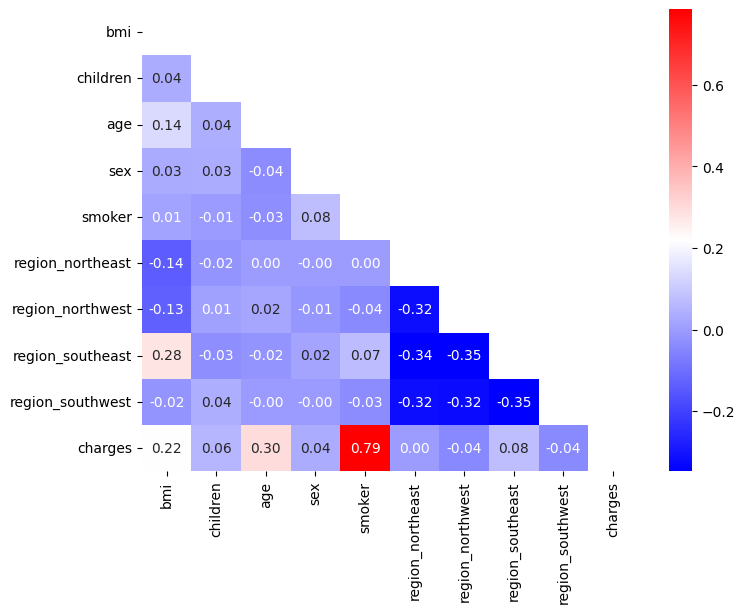

In [55]:
corr_train_pearson = data_train.corr(method='pearson')
viz_heatmap(corr_train_pearson)

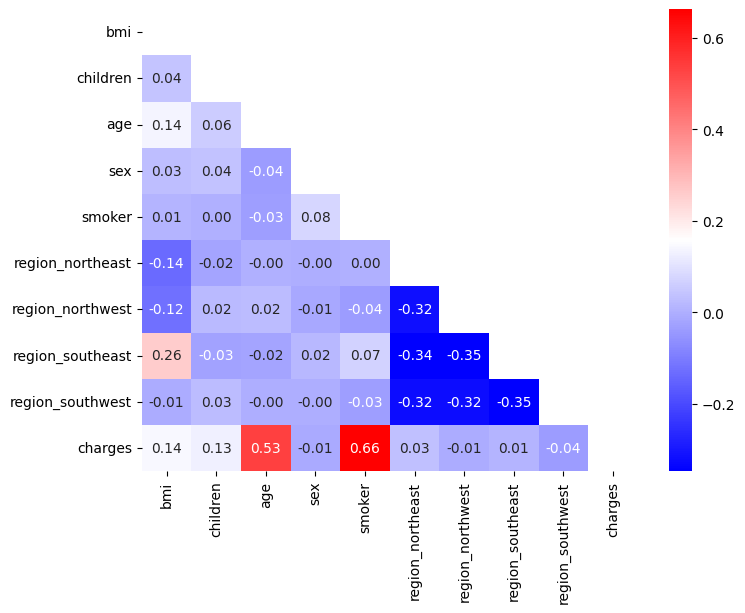

In [56]:
corr_train_spearman = data_train.corr(method='spearman')
viz_heatmap(corr_train_spearman)

Based on the results of the correlation checks with Spearman and Pearson, as well as the analysis conducted on the entire dataset and the data after splitting, we can assume that the features influencing insurance bills are "smoker," "age," "bmi," and "children."

# <a id='8' href=#1> Model Development </a>

In this section, we will attempt to train the model using linear regression and random forest. First, we will try using all the features.

## <a id='8.1' href="#1"> Linear regression with all features </a>

In [57]:
X_train_new.shape

(1069, 9)

In [58]:
model_linreg_1= LinearRegression()

#Train our data using linear regression
model_linreg_1.fit(X_train_new, y_train)

LinearRegression()

In [59]:
X_train_new

,bmi,children,age,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,0.296013,0.6,0.152174,1.0,0.0,0.0,0.0,0.0,1.0
1,0.377936,0.0,0.021739,0.0,0.0,0.0,0.0,0.0,1.0
2,0.444293,0.2,0.152174,0.0,0.0,0.0,0.0,1.0,0.0
3,0.539596,0.4,0.543478,0.0,0.0,1.0,0.0,0.0,0.0
4,0.378209,0.4,0.565217,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
1064,0.528127,0.6,0.478261,1.0,0.0,0.0,0.0,0.0,1.0
1065,0.249044,0.0,0.934783,0.0,0.0,0.0,0.0,1.0,0.0
1066,0.601857,0.6,0.347826,0.0,0.0,0.0,0.0,0.0,1.0
1067,0.259421,0.0,0.260870,1.0,0.0,1.0,0.0,0.0,0.0


In [60]:
class ModelEvaluator:
    def __init__(self, train_actual=None, train_predicted=None, test_actual=None, test_predicted=None):
        # Initialize the ModelEvaluator with actual and predicted values for both training and testing datasets
        self.train_actual = train_actual
        self.train_predicted = train_predicted
        self.test_actual = test_actual
        self.test_predicted = test_predicted

    def calculate_metrics(self, y_true, y_pred):
        # Calculate various evaluation metrics for a given set of true and predicted values
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        metrics = {
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'R-squared': r2.round(2)
        }

        return metrics 

    def evaluate(self):
        metrics = {}

        if self.train_actual is not None and self.train_predicted is not None:
            # Calculate and store evaluation metrics for the training dataset
            train_metrics = self.calculate_metrics(self.train_actual, self.train_predicted)
            metrics['Train'] = train_metrics

        if self.test_actual is not None and self.test_predicted is not None:
            # Calculate and store evaluation metrics for the testing dataset
            test_metrics = self.calculate_metrics(self.test_actual, self.test_predicted)
            metrics['Test'] = test_metrics

        # Return the evaluation metrics in a DataFrame
        return pd.DataFrame(metrics)

In [61]:
y_train_pred= model_linreg_1.predict(X_train_new)
y_test_pred= model_linreg_1.predict(X_test_new)

In [62]:
evaluator_test = ModelEvaluator(test_actual=y_test, test_predicted=y_test_pred)
evaluator_test.evaluate()

,Test
MAE,4092.098247
MAPE,0.451835
R-squared,0.750000
RMSE,6026.874838


In [63]:
evaluator_both = ModelEvaluator(train_actual=y_train, train_predicted= y_train_pred,
                                 test_actual=y_test, test_predicted=y_test_pred)

evaluator_both.evaluate().round(3)

,Train,Test
MAE,4213.988,4092.098
RMSE,6053.895,6026.875
MAPE,0.419,0.452
R-squared,0.750,0.750


## <a id='8.2' href="#1"> Linear regression with top 4 features </a>

In [64]:
top_4_corr= corr_train_spearman.charges.abs().nlargest(5) 
top_4_corr= top_4_corr[top_4_corr < 1]
print(top_4_corr)

selected_features= X_train_new[top_4_corr.index].columns
selected_features

smoker      0.662776
age         0.534120
bmi         0.141913
children    0.127283
Name: charges, dtype: float64


Index(['smoker', 'age', 'bmi', 'children'], dtype='object')

In [65]:
model_linreg_2= LinearRegression()

#Train our data using linear regression
model_linreg_2.fit(X_train_new[selected_features], y_train)

y_train_pred= model_linreg_2.predict(X_train_new[selected_features])
y_test_pred= model_linreg_2.predict(X_test_new[selected_features])

In [66]:
evaluator_both_top4 = ModelEvaluator(train_actual=y_train, train_predicted= y_train_pred,
                                 test_actual=y_test, test_predicted=y_test_pred)

evaluator_both_top4.evaluate().round(3)

,Train,Test
MAE,4225.115,4068.594
RMSE,6065.863,6030.892
MAPE,0.423,0.446
R-squared,0.750,0.750
